In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import matplotlib as mpl

# Define as configurações de fonte para usar LaTeX
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.serif'] = ['Computer Modern Roman']
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.linewidth'] = 1.5

# Questão 1

Amostrar um sinal $x(t) = \sin (2\pi f t)$ e fazer modulação/demodulação PCM com $k$ bits de quantização.

Atentar para:

- Amostragem
- Quantização (uniforme)
- Codificação (binária)



## Quantização

$$Q(x_i , A, k) = A \cdot \lfloor \frac{x_i}{A} \cdot 2^k \rceil / 2^k$$ 

In [77]:
def quantize(x, a, k):
    # x = sampled signal to quantize
    # a = amplitude
    # k = bits
    l = 2**k
    a * np.round(x/a * l) / l

In [78]:
def binary(ns, k):
    fstr = "{0:0" + f'{k}b' + "}"
    vs = []
    for n in ns:
        vs.append(fstr.format(int(n)))
    return np.array(vs)

In [79]:
binary([0, 1, 2, 3], 2)

array(['00', '01', '10', '11'], dtype='<U2')

In [80]:
def quantization_index(x, a, k):
    # x = sampled signal to quantize
    # a = amplitude
    # k = bits
    l = 2**k
    return binary(np.round(0.5 * (1 + x/a) * (l-1)), k)

In [81]:
s = np.random.uniform(-5.0, 5.0, size=10)
print(f"s = {s}")
v = quantization_index(s, 5.0, 2)

s = [-2.75825505 -0.91892341 -0.19024393 -2.94205616 -4.57025212  0.33557928
 -3.14033192  4.54749339 -3.41168055 -2.2194293 ]


In [82]:
def pulse_sequence(v):
    str_numbers = ''.join(v)
    return np.array([int(x) for x in str_numbers])

In [93]:
def pcm_plot(v):
    x_q = pulse_sequence(v)
    # hold each pulse for the sampling period T
    n = len(x_q)
    # must be rectangle plot
    #plt.stem(np.arange(n), x_q, 'k', markerfmt='ko', use_line_collection=True)
    # plot rectangular pulses
    plt.step(np.arange(n), x_q, 'k')
    # x title
    plt.xlabel(r'Índice da amostra $n \propto t$')


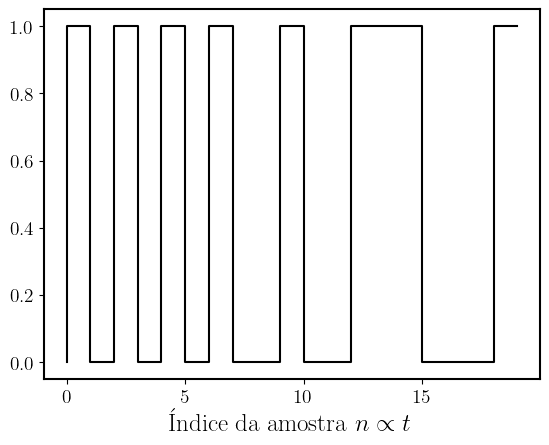

In [94]:
pcm_plot(quantization_index(s, 5.0, 2))

In [98]:
# sin(2pift)
def pcm(f, a, k, n):
    # n = samples
    # a = amplitude
    # f = frequency
    # k = bits
    t = np.linspace(0.0, 1.0, num=n)
    x = a * np.sin(2*np.pi*f*t)
    return quantization_index(x, a, k)

Índices de quantização = ['10' '10' '11' '11' '11' '11' '10' '10' '01' '00' '00' '00' '00' '01'
 '01' '10' '10' '11' '11' '11' '11' '10' '01' '01' '00' '00' '00' '00'
 '01' '01']
Índices de quantização = [2, 2, 3, 3, 3, 3, 2, 2, 1, 0, 0, 0, 0, 1, 1, 2, 2, 3, 3, 3, 3, 2, 1, 1, 0, 0, 0, 0, 1, 1]


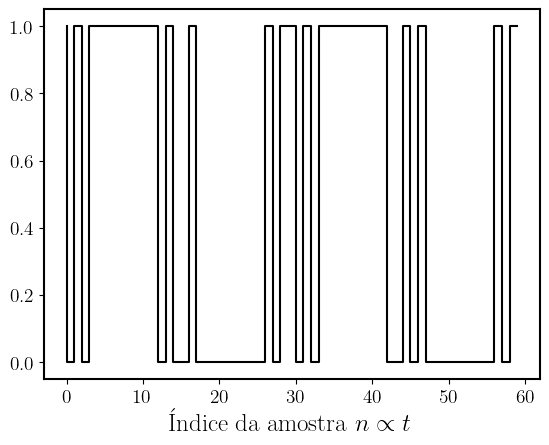

In [161]:
y = pcm(60.0, 5.0, 2, 30)
print(f"Índices de quantização = {y}")
pcm_plot(y)

In [167]:
def pcm_decodification(y, a, k):
    # y = modulated signal indexed by integers
    # a = amplitude
    # k = bits
    delta = a / (2**(k-1))
        
    return np.array([int(x, 2) * delta - a + delta/2 for x in y])

In [170]:
decoded = pcm_decodification(y, 5.0, 2)

Text(0.5, 0, 'Índice da amostra $n \\propto t$')

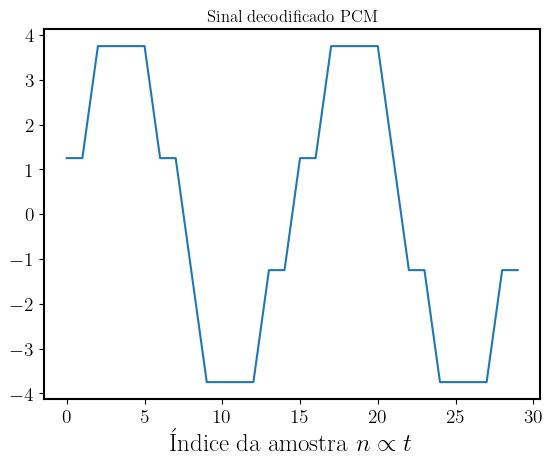

In [171]:
plt.plot(decoded)
plt.title(r'Sinal decodificado PCM')
plt.xlabel(r'Índice da amostra $n \propto t$')

## Demodulação

$$x^*(t) = \sum_{n=-\infty}^{\infty} x_d(n) \text{sinc}(t/T_s - n)$$

In [178]:
def x_demod(t, x_d, t_s):
    # t_s = sampling period
    # x_d = decoded signal
    # t = time
    return np.convolve(np.sinc(t/t_s), x_d, mode='same')

In [179]:
# apply scipy's IIR low pass filter to the decoded signal to obtain the demodulated signal
from scipy import signal

def pcm_demodulation(x_d, f_c, fs):
    # x_d = decoded signal
    # f_c = cutoff frequency
    # fs = sampling frequency
    # apply scipy's IIR low pass filter to the decoded signal60.0, to obtain the demodulated signal
    b, a = signal.iirfilter(4, f_c, btype='lowpass', fs=fs)
    return signal.filtfilt(b, a, x_d)

In [180]:
demodulated = pcm_demodulation(decoded, 100.0, 1000.0)

Text(0.5, 0, 'Índice da amostra $n \\propto t$')

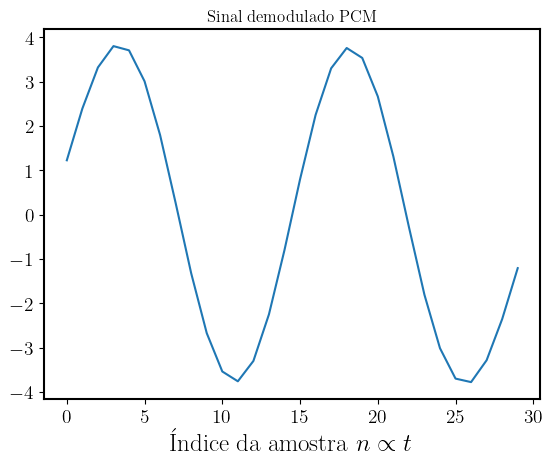

In [182]:
plt.plot(demodulated)
plt.title(r'Sinal demodulado PCM')
plt.xlabel(r'Índice da amostra $n \propto t$')

# Questão 2

Repita o procedimento anterior considerando um  ́audio (sugestão “train”) como sinal de entrada.

(3000.0, 3200.0)

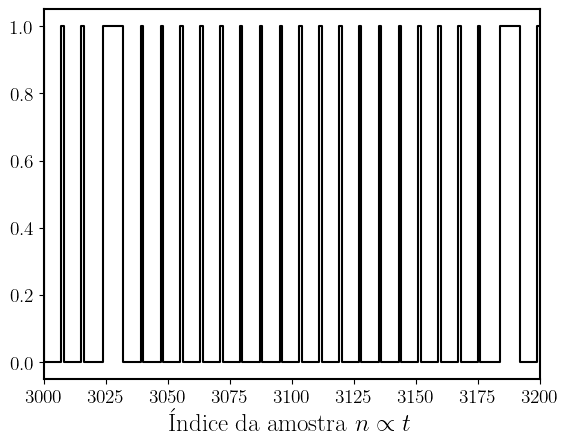

In [193]:
# Carregar áudio
fs, x = wavfile.read('steam_train.wav')
# Como o áudio é estéreo, vamos pegar apenas um canal
x = x[:, 0]
a = np.max(np.abs(x))
x_q = quantization_index(x, a, 8)
pcm_plot(x_q)
plt.xlim(3000, 3200)


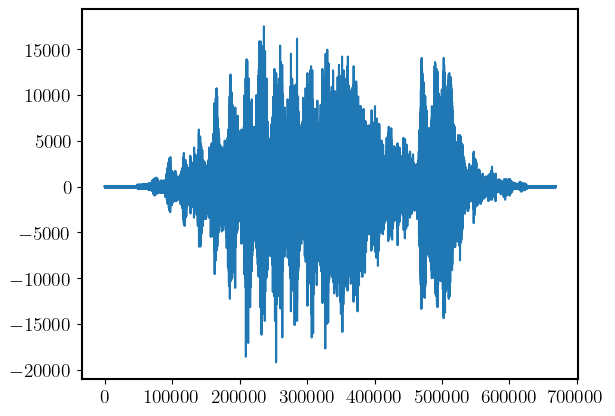

In [194]:
#
decoded = pcm_decodification(x_q, a, 8)
plt.plot(decoded)

In [ ]:
# DM modulation/demodulation

def dm_modulation(x, k):
    x_q = np.diff(x) <= 0
    x_q = x_q[]
    # convert diff to 0(if dx<= 0) or 1(if dx>0)


In [204]:
signal = np.random.uniform(-5.0, 5.0, size=10)
print(f"signal = {signal}")
y = np.concatenate(([0.0], (np.diff(signal) > 0).astype(float)))
print(f"DM(y) = {y}")

signal = [ 0.57730032 -3.87334522  3.75089825  2.17555786  1.9813839  -4.42327987
 -1.08428195 -0.00750996 -4.17598276  0.50707731]
DM(y) = [0. 0. 1. 0. 0. 0. 1. 1. 0. 1.]
